In [200]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# GLOBAL
nonDataCols = ['patient_id', 'sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)','patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)','patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']

> read data

In [201]:
raw_data = pd.read_excel('data/dataset.xlsx', engine="openpyxl")

raw_data.info()
raw_data.describe()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> data obeservation

,patient_age_quantile,hematocrit,hemoglobin,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration (mchc),leukocytes,basophils,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
Total,0,5041,5041,5042,5045,5042,5042,5042,5042,5042,...,5617,5617,5617,5617,5617,5617,5617,5624,5624,5617
Percent,0.0,89.316088,89.316088,89.333806,89.38696,89.333806,89.333806,89.333806,89.333806,89.333806,...,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.645641,99.645641,99.521616
Types,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


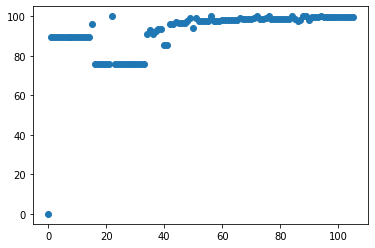

In [202]:
raw_data.columns = [x.lower().strip().replace(' ','_') for x in raw_data.columns]

def show_missing_features(x):
    total = x.isnull().sum()
    percent = (x.isnull().sum()/x.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in raw_data.columns:
        dtype = str(x[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

obs = show_missing_features(raw_data)
for x in nonDataCols:
    obs.drop(columns=[x], inplace=True)

[percent] = obs[1:2].values
plt.scatter([i for i in range(0, obs.shape[1])], percent)
obs.head()

> data cleaning

In [203]:
# Fill in missing features

for x in raw_data.columns:
    if raw_data[x].dtype=='float16' or  raw_data[x].dtype=='float32' or  raw_data[x].dtype=='float64':
        raw_data[x].fillna(raw_data[x].mean())

raw_data = raw_data.fillna(-999)

# Convert label-typed features
for y in raw_data.columns:
    if raw_data[y].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(raw_data[y].values))
        raw_data[y] = lbl.transform(list(raw_data[y].values))

raw_data.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,1588,13,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,451,17,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,3669,8,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,5457,5,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,4843,15,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


> feature engineering

In [204]:
# DOING



normalized_data = raw_data - raw_data.mean()

for x in nonDataCols:
    normalized_data.drop(columns=[x], inplace=True)
#normalized_data.head(20)


pca_size = 47
pca = PCA(n_components=pca_size)
pca.fit(normalized_data)

pca_data = pd.DataFrame(pca.transform(normalized_data),
columns=['feature%s' % _ for _ in range(pca_size)],
index=raw_data.index)

for i, v in enumerate(nonDataCols):
    pca_data.insert(i, v, raw_data[v])

pca_data.head(10)

,patient_id,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",feature0,feature1,feature2,feature3,feature4,...,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46
0,1588,0,0,0,0,-459.185996,21.369325,-1.954074,-1.368605,-3.335151,...,0.012060,-0.016240,-0.004361,-0.011562,0.008489,0.003054,0.000278,0.003789,-0.001483,0.007016
1,451,0,0,0,0,3825.040571,-963.485107,-354.400607,23.375124,-1162.404300,...,0.445953,0.797193,0.176922,-0.584189,0.073771,-0.565986,0.750410,-0.222664,-0.482858,-0.912780
2,3669,0,0,0,0,-459.188455,21.369152,-1.948759,-1.370712,-3.330891,...,-0.016393,-0.006550,0.010755,0.010373,-0.012646,-0.001985,0.007861,0.000905,0.001872,-0.004529
3,5457,0,0,0,0,-459.189931,21.369047,-1.945570,-1.371976,-3.328335,...,-0.033465,-0.000735,0.019824,0.023534,-0.025328,-0.005008,0.012411,-0.000825,0.003885,-0.011456
4,4843,0,0,0,0,-459.178808,21.372791,-1.957604,-1.365832,-3.343659,...,0.028789,-0.031668,0.004029,-0.028302,-0.037141,-0.067115,0.082478,0.019386,-0.036275,0.093176
5,2665,0,0,0,0,-459.187963,21.369186,-1.949822,-1.370290,-3.331743,...,-0.010702,-0.008488,0.007731,0.005986,-0.008419,-0.000977,0.006344,0.001482,0.001201,-0.002220
6,1008,0,0,0,0,-459.185996,21.369325,-1.954074,-1.368605,-3.335151,...,0.012060,-0.016240,-0.004361,-0.011562,0.008489,0.003054,0.000278,0.003789,-0.001483,0.007016
7,1832,0,0,0,0,-459.184521,21.369430,-1.957263,-1.367341,-3.337706,...,0.029132,-0.022054,-0.013430,-0.024723,0.021170,0.006077,-0.004271,0.005519,-0.003497,0.013943
8,3121,0,0,1,0,4684.390877,1639.440863,-419.589351,1287.967464,-486.718539,...,-0.510201,-1.482150,-2.332875,-1.024019,0.074456,0.060515,0.005512,-1.730967,-0.722305,1.664933
9,2186,0,0,0,0,-459.177650,21.372972,-1.959788,-1.364922,-3.345556,...,0.015380,-0.020591,-0.053799,-0.046460,-0.047643,0.015555,-0.042718,0.000142,0.005897,-0.017547


> model training

> cross validation

In [12]:
df = pd.DataFrame(data=np.random.normal(0, 1, (20, 10)))
df.info()
df.describe()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20 non-null     float64
 1   1       20 non-null     float64
 2   2       20 non-null     float64
 3   3       20 non-null     float64
 4   4       20 non-null     float64
 5   5       20 non-null     float64
 6   6       20 non-null     float64
 7   7       20 non-null     float64
 8   8       20 non-null     float64
 9   9       20 non-null     float64
dtypes: float64(10)
memory usage: 1.7 KB


,0,1,2,3,4,5,6,7,8,9
0,0.587796,-0.241425,0.448883,-1.497244,0.508049,0.723766,0.248562,1.430984,0.538177,-0.104221
1,0.876398,-0.081532,0.547025,-2.121276,1.009623,-1.185060,0.932510,-1.708317,0.979762,-0.713940
2,-0.083633,0.840701,-0.786257,1.370967,0.942155,1.077248,-0.122839,0.245831,0.874436,-1.373428
3,-0.487453,-0.618074,0.772788,-0.140002,-0.793393,-0.342872,0.270904,0.377417,-1.026956,-0.400866
4,1.075252,0.225908,0.637844,-1.765464,0.483948,0.934140,0.296562,0.135826,-2.064693,0.148604
5,-0.395069,-0.470977,0.262600,-0.148242,-2.300116,0.587677,-2.017454,0.771570,0.951013,-0.493046
6,-0.749004,0.398668,-0.269225,0.367458,0.740914,-1.003194,-0.736553,0.293201,0.234389,0.540144
7,-0.353992,-0.840135,0.242180,1.804821,-0.806561,-0.043784,0.058479,1.153340,-0.378177,-0.220695
8,1.323458,-2.407041,-1.838734,-0.432739,1.069783,0.559577,-1.277839,-1.302350,-0.506398,1.317513
9,-0.351995,0.969183,1.331187,1.395055,-1.108463,0.913349,0.084180,1.104777,-0.272918,0.277918


> evaluation